# Section 1: binary phase evaluation (fixed parameters)

We model a binary system embedded in an accretion disk, along with a dark matter spike and gravitational waves emission.
The goal for our modelization is to produce an estimate of the following quantity: 

\begin{equation}
    \dot{r} = \dot{r}_{\mathrm{gas}} + \dot{r}_{\mathrm{DF}} + \dot{r}_{\mathrm{GW}}\text{,}
\end{equation}

where $\dot{r}_\mathrm{gas}$ is the contribution coming from gas torques from the accretion disk surrounding the binary, $\dot{r}_\mathrm{DF}$ is the effect of dynamical friction from the presence of the dark matter spike, and $\dot{r}_\mathrm{GW}$ is the contribution from the gravitational waves emission. Specifically, we adopt the classical Newtonian formalism, computing the results from the reduced mass-system, and in case assuming that $m_1 \gg m_2$.

Once the shape of $\dot{r}$ is clear, one can evaluate the phase of the binary system from a generic $f$-frequency to the $f_{\mathrm{isco}}$-frequency. Assuming circular orbits the frequency is:

\begin{equation}
    f = \frac{1}{\pi} \sqrt{\frac{G(m_1 + m_2)}{r^3}}\text{.}
\end{equation}

We can evaluate $\Phi(f)$ as: 

\begin{equation}
    \Phi(f) = \int_{f}^{f_{\mathrm{isco}}} \frac{dt}{df'} f' df'\text{,}
\end{equation}

where the relation $\frac{dt}{df'}$ is extracted directly from the expression in the above equation by the following chain rule: $\frac{dr}{dt} \frac{df}{dr} = \frac{df}{dt}$. 

## Expressions for the $\dot{r}_i$ contributions

- Accretion disk's torques: 

\begin{equation}
    \dot{r}_\mathrm{gas} = - 2 \Sigma_0 \frac{r^{\gamma + 3/2}}{r_0^\gamma} \frac{G^{1/2} (m_1 + m_2)^{1/2}}{\mu} q^{2} \mathcal{M}^2\text{.}
\end{equation}

- Dark matter spike's dynamical friction:

Static:

\begin{equation}
\label{eq:r_dot_DF}
    \dot{r}_{\mathrm{DF}} = - \frac{8 \pi G^{\frac{1}{2}} \mu \log{(\Lambda)} \rho_6 r_6^{\gamma_s} \xi(v)}{r^{\gamma_s - \frac{5}{2}}(m_1 + m_2)^{\frac{3}{2}}}\text{,}
\end{equation}

Time dependent:

\begin{equation}
\label{eq:r_dot_DF_time}
    \dot{r}_{\mathrm{DF}} = - \frac{8 \pi G^{\frac{1}{2}} \mu \log{(\Lambda)} \rho_6 r_6^{\gamma_s} \xi(v)}{r^{\gamma_s - \frac{5}{2}}(m_1 + m_2)^{\frac{3}{2}}} \cdot r^{-5/2}\text{.}
\end{equation}

- Gravitational waves: 

\begin{equation}
\label{eq:r_dot_gw}
    \dot{r}_{\mathrm{GW}} = - \frac{64 (m_1 + m_2) G^3 m_1 m_2}{5 c^5 r^3}\text{.}
\end{equation}

In the code, there will be enabled the possibility to choose which of these options to keep in the final formula, which will account for the sum of all the contributions the user requires. 

## Formulas to use and implement "in code" for the phase evaluation

I used the following quantities: 

- Derivative of f in radial separation:

\begin{equation}
\label{eq:dfdr}
    \frac{df}{dr} = \frac{1}{\pi} (-\frac{3}{2}) \sqrt{\frac{G (m_1 + m_2)}{r^5}}\text{.}\\
\end{equation}


- Inverse of f(r):

\begin{equation}
\label{eq:r(f)}
    r(f) = \sqrt[3]{\frac{G (m_1 + m_2)}{\pi^2 f^2}}\text{,}\\
\end{equation}

- Derivative of f in time:

\begin{equation}
\label{eq:dfdt}
    \frac{df}{dt} = \dot{r} \frac{df}{dr}\text{,}\\
\end{equation}

- Second derivative of the phase in time:

\begin{equation}
\label{eq:phi_dot-dot}
    \ddot{\Phi}(f) = 4 \pi^2 f \left(\frac{d\Phi(f)}{df}\right)^{-1} 
\end{equation}

# Code implementation

### Libraries and classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scipy as sp
from scipy.integrate import quad 

In [2]:
class Phase_Evaluation:
    
    def __init__(self, m1, m2, mach, sigma0, gamma, gammas, rho6, r6, epsv, dist): 
        
        self.G = 6.67 * 1e-11 # kg m^3 / s^2
        self.c = 3 * 1e8 # m / s
        self.m1 = m1
        self.m2 = m2
        self.M_tot = self.m1 + self.m2
        self.mach = mach
        self.r0 = 6 * self.G * self.m1 / self.c**2 # 3 * r_s
        self.mu = self.m1 * self.m2 / (self.m1 + self.m2)
        self.q = self.m2/self.m1
        self.sigma0 = sigma0 / self.mach**2
        self.gamma = gamma
        self.logL = 1 / (self.q)**(1/2)
        self.gammas = gammas
        self.rho6 = rho6
        self.r6 = r6
        self.epsv = epsv
        self.dist = dist
        self.chirp_mass = (self.m1 * self.m2)**(3/5) / (self.M_tot)**(1/5)
    
    
    def rho_dm(self, r):
        '''Finds the density profile of the dark matter using the above formulation.'''
        return self.rho0 * (self.r0 / r)**(self.gamma)
    
    def sigma_acc(self, r): 
        return self.sigma0 * (r / self.r0)**(self.gamma)

    def rho_disk(self, r):
        '''Finds the density profile of the disk using \rho \simeq \Sigma(r)/(2h), where h = r / Mach.'''
        return self.sigma_acc(self, r) / (2 * r / self.mach) # set h = r / Mach

    def frequency(self, r):
        '''Finds the binary frequency assuming circular orbits, at fixed radius r.'''
        return 1 / np.pi * np.sqrt(self.G * self.M_tot / r**3)

    def df_dr(self, r): 
        '''Finds the binary frequency radial derivative assuming circular orbits.'''
        return 1 / np.pi * (- 3 / 2) * np.sqrt(self.G * self.M_tot / r**5)

    def gas_torque(self, r): 
        return - self.sigma_acc(r) * r**4 * (self.G * self.M_tot / r**3) * self.q**2 * self.mach**2

    def yes_or_no(self, elem):
        '''Checks whether you want a contribution or not. (could be made boolean directly)'''
        if elem=='y': 
            return 1
        return 0

    def dot_r(self, r):
        '''Find the binary change in separation over time, asking the user to choose which contribution to keep.'''
            
        acc = ''
        dm = ''
        gw = ''
        
        while(acc != 'y' and acc != 'n'):
            print('Include the accretion contribution? (y/n)')
            acc = input()
        
        while(dm != 'y' and dm != 'n'):
            print('Include the dark matter contribution? (y/n)')
            dm = input()
        
        while(gw != 'y' and gw != 'n'):
            print('Include the GW contribution? (y/n)')
            gw = input()
            
        print('-----')
        
        r_dot_acc = 0.5 * self.gas_torque(r) * self.m2**(-1) * r**(1/2) * (self.G * self.M_tot)**(-1/2)
        
        r_dot_dm = - 8 * np.pi * self.G**(1/2) * self.m2 * self.logL * self.rho6 * self.r6**(self.gammas) * self.epsv / (r**(self.gammas - 5/2) * self.m1 * self.M_tot**(1/2)) #* r**(5/2)
        
        r_dot_gw = - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)
        
        
        return self.yes_or_no(acc) * r_dot_acc + self.yes_or_no(dm) * r_dot_dm + self.yes_or_no(gw) * r_dot_gw

    def dot_r_acc(self, r):
        
        r_dot_acc = 0.5 * self.gas_torque(r) * self.m2**(-1) * r**(1/2) * (self.G * self.M_tot)**(-1/2)
        r_dot_gw = - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)
        
        return r_dot_gw + r_dot_acc
    
    def dot_r_all(self, r):
        
        r_dot_gw = - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)
        r_dot_dm = - 8 * np.pi * self.G**(1/2) * self.m2 * self.logL * self.rho6 * self.r6**(self.gammas) * self.epsv / (r**(self.gammas - 5/2) * self.m1 * self.M_tot**(1/2)) 
        r_dot_acc = 0.5 * self.gas_torque(r) * self.m2**(-1) * r**(1/2) * (self.G * self.M_tot)**(-1/2)
        
        return r_dot_gw + r_dot_dm + r_dot_acc
        
    def dot_r_dm(self, r):
        
        r_dot_gw = - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)
        r_dot_dm = - 8 * np.pi * self.G**(1/2) * self.m2 * self.logL * self.rho6 * self.r6**(self.gammas) * self.epsv / (r**(self.gammas - 5/2) * self.m1 * self.M_tot**(1/2)) 
        
        return r_dot_gw + r_dot_dm
        
        
    def dot_r_gw(self, r):
        
        return - 64 * self.M_tot * self.G**3 * self.m1 * self.m2 / (5 * self.c**5 * r**3)
    
    
    def df_dt(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r(r)
    
    def df_dt_all(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r_all(r)
    
    def df_dt_gw(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r_gw(r)
    
    def df_dt_dm(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r_dm(r)
    
    def df_dt_acc(self, r): 
        '''Finds the binary frequency time derivative.'''
        return self.df_dr(r) * self.dot_r_acc(r)

    def phase_f_by_hand(self, r): 
        '''Finds the binary phase as a function of frequency.'''
        
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt(r)**(-1) * self.frequency(r) 
        phase_f = []
        
        for b in freqs:  # range of values for the lower limit
            
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
    
        return np.array(phase_f)
    
    def phase_f_by_hand_dm(self, r): 
        '''Finds the binary phase as a function of frequency.'''
        
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt_dm(r)**(-1) * self.frequency(r) 
        phase_f = []
        
        for b in freqs:  # range of values for the lower limit
            
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
    
        return np.array(phase_f)
    
    def phase_f_by_hand_acc(self, r): 
        '''Finds the binary phase as a function of frequency.'''
        
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt_acc(r)**(-1) * self.frequency(r) 
        phase_f = []
        
        for b in freqs:  # range of values for the lower limit
            
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
    
        return np.array(phase_f)
    
    def phase_f_by_hand_all(self, r): 
        '''Finds the binary phase as a function of frequency.'''
        
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt_all(r)**(-1) * self.frequency(r) 
        phase_f = []
        
        for b in freqs:  # range of values for the lower limit
            
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
    
        return np.array(phase_f)
    
    def phase_f_by_hand_gw(self, r): 
        '''Finds the binary phase as a function of frequency.'''
        
        freqs = self.frequency(r)
        to_integrate = 2 * np.pi * self.df_dt_gw(r)**(-1) * self.frequency(r) 
        phase_f = []
        
        for b in freqs:  # range of values for the lower limit
            
            # Select the appropriate range of f values for integration
            f_range = freqs[freqs >= b]
            
            phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))
    
        return np.array(phase_f)


    def ddot_phase(self, r): 
        '''Finds the binary second derivative phase as a function of frequency, using the equations above.'''
        return 2 * np.pi * self.df_dt(r)

    
    def h_0(self, r):
        '''Finds the strain as a function of frequency, and \ddot{\Phi}'''
        
        return 1/2 * 4 * np.pi**(2/3) * self.G**(5/3) * self.chirp_mass**(5/3) * self.frequency(r)**(2/3) / self.c**4 * (2 * np.pi / self.ddot_phase(r))**(1/2) / (self.dist)
        

In [3]:
# Define some outside constants

pc = 3.09 * 1e16 # m
m_sun = 2 * 1e30 # kg

In [4]:
phase_model = Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = 1.5 * 1e10, 
    gamma = -1/2, 
    gammas = 7/3, 
    rho6 = 1.17 * 1e17 * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)

In [5]:
# Set a grid of radial distances
m1 = m_sun * 1e5
G = 6.67 * 1e-11
c = 3 * 1e8
r_s = 2 * m1 * G / c**2
r_isco = 6 * m1 * G / c**2

r_grid_0 = np.linspace(r_s, 250 * r_s, 10000)
r_grid = np.linspace(r_isco, 150 * r_isco, 10000)

In [6]:
# Evaluate the frequencies
freqs = phase_model.frequency(r_grid)
f_isco = phase_model.frequency(r_isco)

In [7]:
phi_all = phase_model.phase_f_by_hand(r_grid)
phi_dm = phase_model.phase_f_by_hand(r_grid)
phi_acc = phase_model.phase_f_by_hand(r_grid)
phi_gw = phase_model.phase_f_by_hand(r_grid)

Include the accretion contribution? (y/n)
y
Include the dark matter contribution? (y/n)
y
Include the GW contribution? (y/n)
y
-----
Include the accretion contribution? (y/n)
n
Include the dark matter contribution? (y/n)
y
Include the GW contribution? (y/n)
y
-----
Include the accretion contribution? (y/n)
y
Include the dark matter contribution? (y/n)
n
Include the GW contribution? (y/n)
y
-----
Include the accretion contribution? (y/n)
n
Include the dark matter contribution? (y/n)
n
Include the GW contribution? (y/n)
y
-----


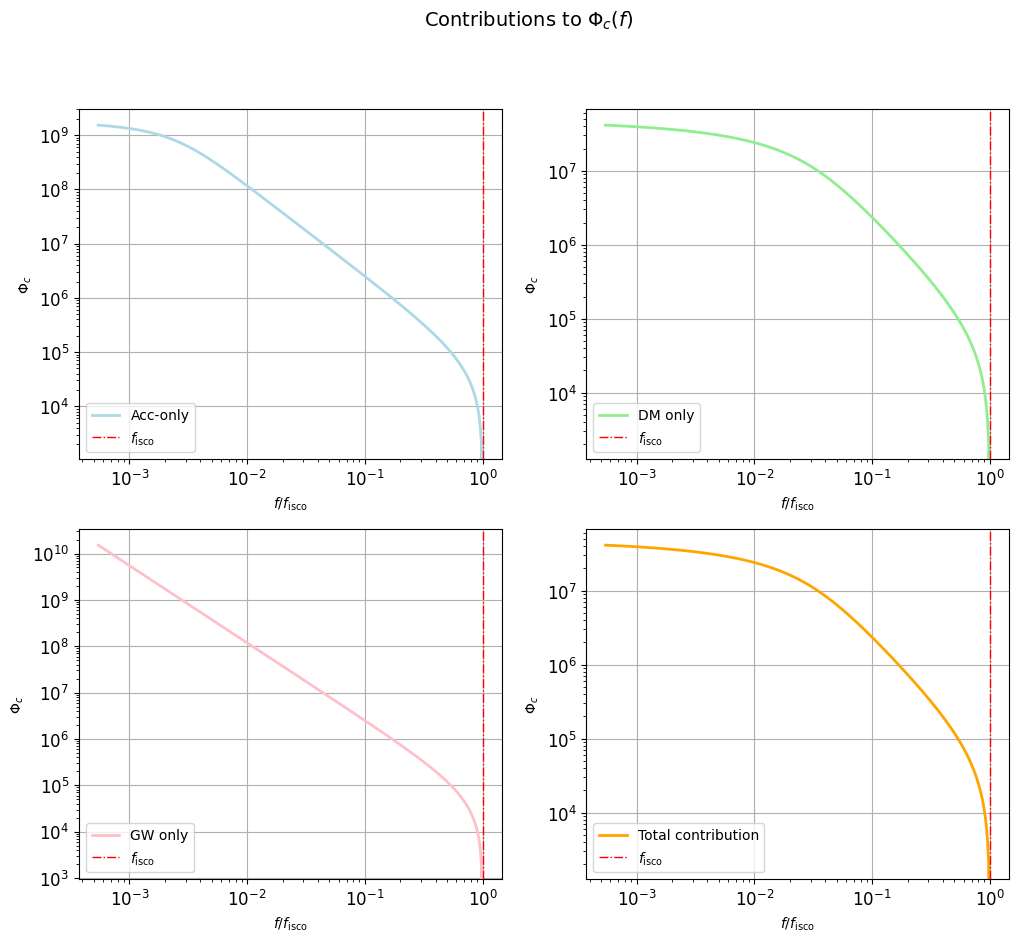

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12,10))

plt.suptitle('Contributions to $\Phi_c(f)$', fontsize=14)


axs[0, 0].loglog(freqs/f_isco, -phi_acc, c='lightblue', linestyle='-', label='Acc-only', linewidth=2)
axs[0, 0].axvline(x=1, c='red', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0, 0].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[0, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 0].grid(True)  # Add gridlines
axs[0, 0].legend()  # Add legend
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[0, 1].loglog(freqs/f_isco, -phi_dm, c='lightgreen', linestyle='-', label='DM only', linewidth=2)
axs[0, 1].axvline(x=1, c='red', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0, 1].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[0, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 1].grid(True)  # Add gridlines
axs[0, 1].legend()  # Add legend
#axs[0, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[1, 0].loglog(freqs/f_isco, -phi_gw, c='pink', linestyle='-', label='GW only', linewidth=2)
axs[1, 0].axvline(x=1, c='red', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[1, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1, 0].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[1, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 0].grid(True)  # Add gridlines
axs[1, 0].legend()  # Add legend
#axs[1, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[1, 1].loglog(freqs/f_isco, -phi_all, c='orange', linestyle='-', label='Total contribution', linewidth=2)
axs[1, 1].axvline(x=1, c='red', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[1, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1, 1].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[1, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 1].grid(True)  # Add gridlines
axs[1, 1].legend()  # Add legend
#axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

plt.show()

In [9]:
h0_all = phase_model.h_0(r_grid)
h0_dm = phase_model.h_0(r_grid)
h0_acc = phase_model.h_0(r_grid)
h0_gw = phase_model.h_0(r_grid)

Include the accretion contribution? (y/n)
y
Include the dark matter contribution? (y/n)
y
Include the GW contribution? (y/n)
y
-----
Include the accretion contribution? (y/n)
n
Include the dark matter contribution? (y/n)
y
Include the GW contribution? (y/n)
y
-----
Include the accretion contribution? (y/n)
y
Include the dark matter contribution? (y/n)
n
Include the GW contribution? (y/n)
y
-----
Include the accretion contribution? (y/n)
n
Include the dark matter contribution? (y/n)
n
Include the GW contribution? (y/n)
y
-----


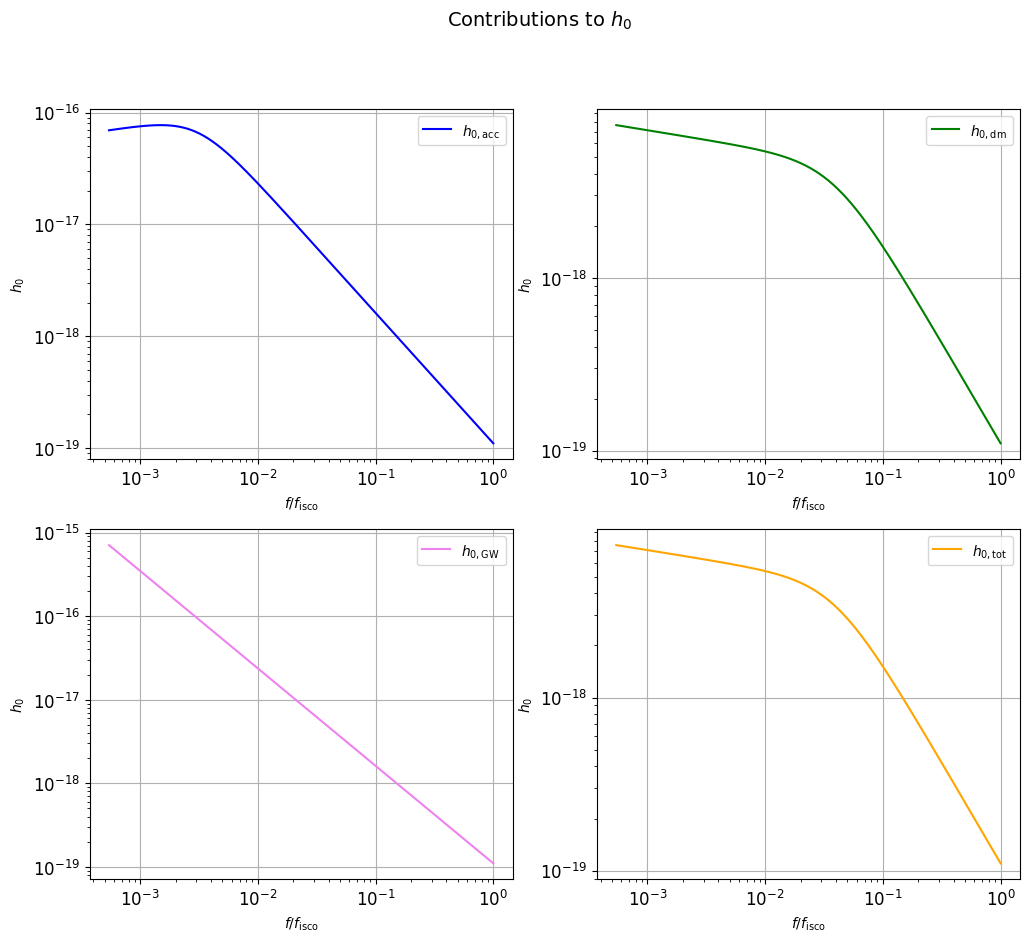

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12,10))

plt.suptitle('Contributions to $h_0$', fontsize=14)


axs[0, 0].loglog(freqs/f_isco, h0_acc, c='blue', linestyle='-', label='$h_{0, \mathrm{acc}}$', linewidth=1.5)
axs[0, 0].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[0, 0].set_ylabel(r'$h_0$', fontsize=10)  # Add y-label with increased font size
axs[0, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 0].grid(True)  # Add gridlines
axs[0, 0].legend()  # Add legend
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[0, 1].loglog(freqs/f_isco, h0_dm, c='green', linestyle='-', label='$h_{0, \mathrm{dm}}$', linewidth=1.5)
axs[0, 1].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[0, 1].set_ylabel(r'$h_0$', fontsize=10)  # Add y-label with increased font size
axs[0, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 1].grid(True)  # Add gridlines
axs[0, 1].legend()  # Add legend
#axs[0, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[1, 0].loglog(freqs/f_isco, h0_gw, c='violet', linestyle='-', label='$h_{0, \mathrm{GW}}$', linewidth=1.5)
axs[1, 0].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[1, 0].set_ylabel(r'$h_0$', fontsize=10)  # Add y-label with increased font size
axs[1, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 0].grid(True)  # Add gridlines
axs[1, 0].legend()  # Add legend
#axs[1, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[1, 1].loglog(freqs/f_isco, h0_all, c='orange', linestyle='-', label='$h_{0, \mathrm{tot}}$', linewidth=1.5)
axs[1, 1].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[1, 1].set_ylabel(r'$h_0$', fontsize=10)  # Add y-label with increased font size
axs[1, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 1].grid(True)  # Add gridlines
axs[1, 1].legend()  # Add legend
#axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

plt.show()

# Section 2: binary phase evaluation VARYING parameters

We now work using the same functions as in the previous section, only varying parameters one by one. More specifically we'll change:

### For the accretion disk:

- The $\gamma$ parameter $\rightarrow \ [-0.4, -0.7]$ ($\beta$-disk regime), possibly changing the upper threshold to match an $\alpha$-disk. Particularly, the scaling relations go as: 

$$\Sigma_\alpha = 5.14 \cdot 10^3 (\frac{\alpha}{0.1})^{-1} (\frac{f_{\mathrm{edd}}}{0.1} \frac{0.1}{\epsilon})^{-1} (\frac{r}{10 M_1})^{3/2} \ \text{kg m}^{-2} ;$$

$$\Sigma_\beta = 2.1 \cdot 10^7 (\frac{\alpha}{0.1})^{-4/5} (\frac{f_{\mathrm{edd}}}{0.1} \frac{0.1}{\epsilon})^{3/5} (\frac{M_1}{10^6 M_{\odot}})^{1/5} (\frac{r}{10 M_1})^{-3/5}.$$

- $\Sigma_0$, just vary from some orders of magnitude and see which produces unphysical stuff; 
- $m_1$ from $1000 M_{\odot} \text{to} \ 10^6 M_{\odot}$. 

### For the dark matter spike:

- The $\gamma_s$ parameter (?);
- $\rho_m$, just vary from some orders of magnitude and see which produces unphysical stuff; 
- $m_1$ from $1000 M_{\odot} \text{to} \ 10^6 M_{\odot}$. 


We look to see how changing just one of these parameters will affect the inspiral. If the dephasing $\Delta\Phi$ increases, this means that the environmental effect is more likely to be detected, while the opposite indicates that a vacuum model wil still be compatible with the phase measured. 

An interesting POV is to find as a threshold the values of densities normalizations such that $\Delta\Phi < 2\pi$ (MY IDEA: set the $\texttt{r_dot}$ such that the normalizations get out of the dephasing and then set $\Sigma = \Delta\Phi / \Delta\Phi_{\mathrm{fake}}$).  

## Accretion disk:

In [11]:
# Build array of gamma values, m_s, and sigma_0s

gamma_vals = np.linspace(-0.4, 1.5, 20)
m1_vals = np.logspace(3, 6, 20)
sigma0_vals = np.logspace(8, 11, 20)

print("Gammas: ", gamma_vals)
print("M1s: ", m1_vals)
print("Sigma0s: ", sigma0_vals)

Gammas:  [-4.00000000e-01 -3.00000000e-01 -2.00000000e-01 -1.00000000e-01
 -5.55111512e-17  1.00000000e-01  2.00000000e-01  3.00000000e-01
  4.00000000e-01  5.00000000e-01  6.00000000e-01  7.00000000e-01
  8.00000000e-01  9.00000000e-01  1.00000000e+00  1.10000000e+00
  1.20000000e+00  1.30000000e+00  1.40000000e+00  1.50000000e+00]
M1s:  [   1000.            1438.44988829    2069.13808111    2976.35144163
    4281.33239872    6158.48211066    8858.6679041    12742.74985703
   18329.80710832   26366.5089873    37926.90190732   54555.94781169
   78475.99703515  112883.78916847  162377.67391887  233572.14690901
  335981.82862838  483293.02385718  695192.79617756 1000000.        ]
Sigma0s:  [1.00000000e+08 1.43844989e+08 2.06913808e+08 2.97635144e+08
 4.28133240e+08 6.15848211e+08 8.85866790e+08 1.27427499e+09
 1.83298071e+09 2.63665090e+09 3.79269019e+09 5.45559478e+09
 7.84759970e+09 1.12883789e+10 1.62377674e+10 2.33572147e+10
 3.35981829e+10 4.83293024e+10 6.95192796e+10 1.00000000e+1

### Varying $\gamma$:

In [12]:
# Find phase variation varying the params: 

phase_model_s = [(Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = 1.5 * 1e10, 
    gamma = gamma_vals[i], 
    gammas = 7/3, 
    rho6 = 1.17 * 1e17 * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)) for i in range(0, len(gamma_vals))]

In [13]:
phi_all_s = [(phase_model_s[i].phase_f_by_hand_all(r_grid)) for i in range(0, len(phase_model_s))]
phi_acc_s = [(phase_model_s[i].phase_f_by_hand_acc(r_grid)) for i in range(0, len(phase_model_s))]
phi_gw_s = [(phase_model_s[i].phase_f_by_hand_gw(r_grid)) for i in range(0, len(phase_model_s))]

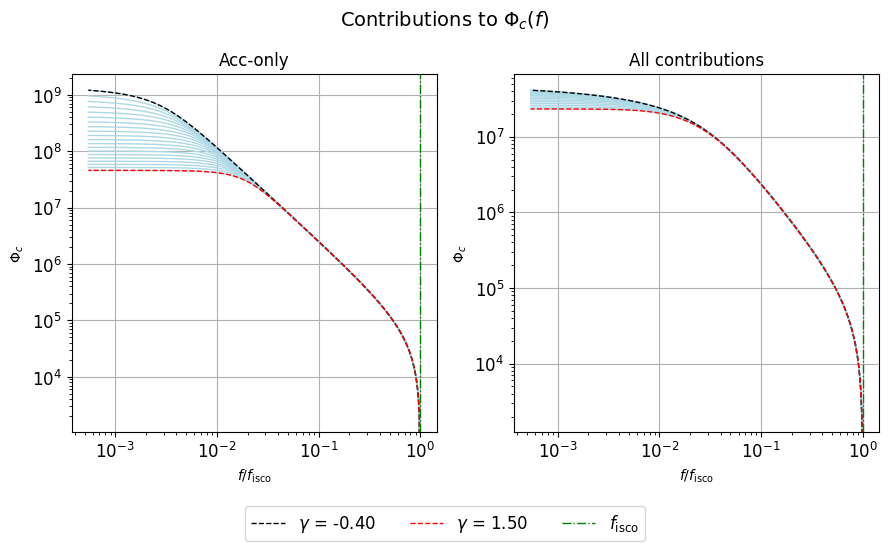

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(9,5))

plt.suptitle('Contributions to $\Phi_c(f)$', fontsize=14)

for i in range(0, len(phi_acc_s)):
    axs[0].loglog(freqs/f_isco, -phi_acc_s[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[0].loglog(freqs/f_isco, -phi_acc_s[0], label=f'$\gamma$ = {gamma_vals[0]:.2f}', linestyle='--', linewidth=1, c='black')
axs[0].loglog(freqs/f_isco, -phi_acc_s[-1], label=f'$\gamma$ = {gamma_vals[-1]:.2f}', linestyle='--', linewidth=1, c='red')
axs[0].axvline(x=1, c='green', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0].grid(True)  # Add gridlines
axs[0].set_title('Acc-only')  # Add gridlines
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(phi_acc_s)):
    axs[1].loglog(freqs/f_isco, - phi_all_s[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[1].loglog(freqs/f_isco, - phi_all_s[0], linestyle='--', linewidth=1, c='black')
axs[1].loglog(freqs/f_isco, - phi_all_s[-1], linestyle='--', linewidth=1, c='red')
axs[1].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1].grid(True)  # Add gridlines
axs[1].set_title('All contributions')  # Add gridlines
#axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/gamma_accretion_phi.png')
plt.show()

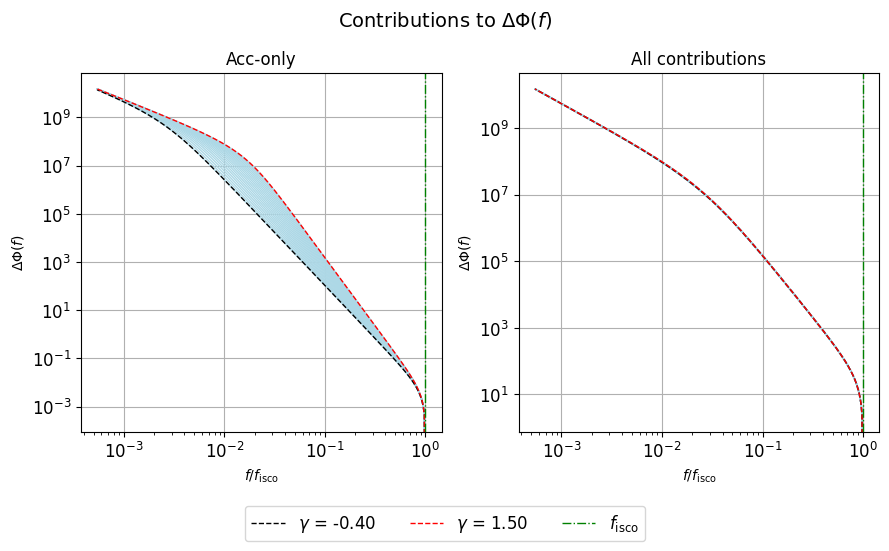

In [15]:
# Dephasing: 

fig, axs = plt.subplots(1, 2, figsize=(9,5))

plt.suptitle('Contributions to $\Delta\Phi(f)$', fontsize=14)

for i in range(0, len(phi_acc_s)):
    axs[0].loglog(freqs/f_isco, phi_acc_s[i] - phi_gw_s[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[0].loglog(freqs/f_isco, phi_acc_s[0] - phi_gw_s[0], label=f'$\gamma$ = {gamma_vals[0]:.2f}', linestyle='--', linewidth=1, c='black')
axs[0].loglog(freqs/f_isco, phi_acc_s[-1] - phi_gw_s[-1], label=f'$\gamma$ = {gamma_vals[-1]:.2f}', linestyle='--', linewidth=1, c='red')
axs[0].axvline(x=1, c='green', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0].grid(True)  # Add gridlines
axs[0].set_title('Acc-only')  # Add gridlines
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(phi_acc_s)):
    axs[1].loglog(freqs/f_isco, phi_all_s[i] - phi_gw_s[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[1].loglog(freqs/f_isco, phi_all_s[0] - phi_gw_s[0], linestyle='--', linewidth=1, c='black')
axs[1].loglog(freqs/f_isco, phi_all_s[-1] - phi_gw_s[-1], linestyle='--', linewidth=1, c='red')
axs[1].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1].grid(True)  # Add gridlines
axs[1].set_title('All contributions')
#axs[0, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/gamma_accretion_DELTA_phi.png')
plt.show()

### Varying $m_1$

In [16]:
# Find phase variation varying the params: 

phase_model_m = [(Phase_Evaluation(

    m1 = m1_vals[i] * m_sun, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = 1.5 * 1e10, 
    gamma = -1/2, 
    gammas = 7/3, 
    rho6 = 1.17 * 1e17 * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)) for i in range(0, len(m1_vals))]

In [17]:
phi_all_m = [(phase_model_m[i].phase_f_by_hand_all(r_grid)) for i in range(0, len(phase_model_m))]
phi_acc_m = [(phase_model_m[i].phase_f_by_hand_acc(r_grid)) for i in range(0, len(phase_model_m))]
phi_dm_m = [(phase_model_m[i].phase_f_by_hand_dm(r_grid)) for i in range(0, len(phase_model_m))]
phi_gw_m = [(phase_model_m[i].phase_f_by_hand_gw(r_grid)) for i in range(0, len(phase_model_m))]

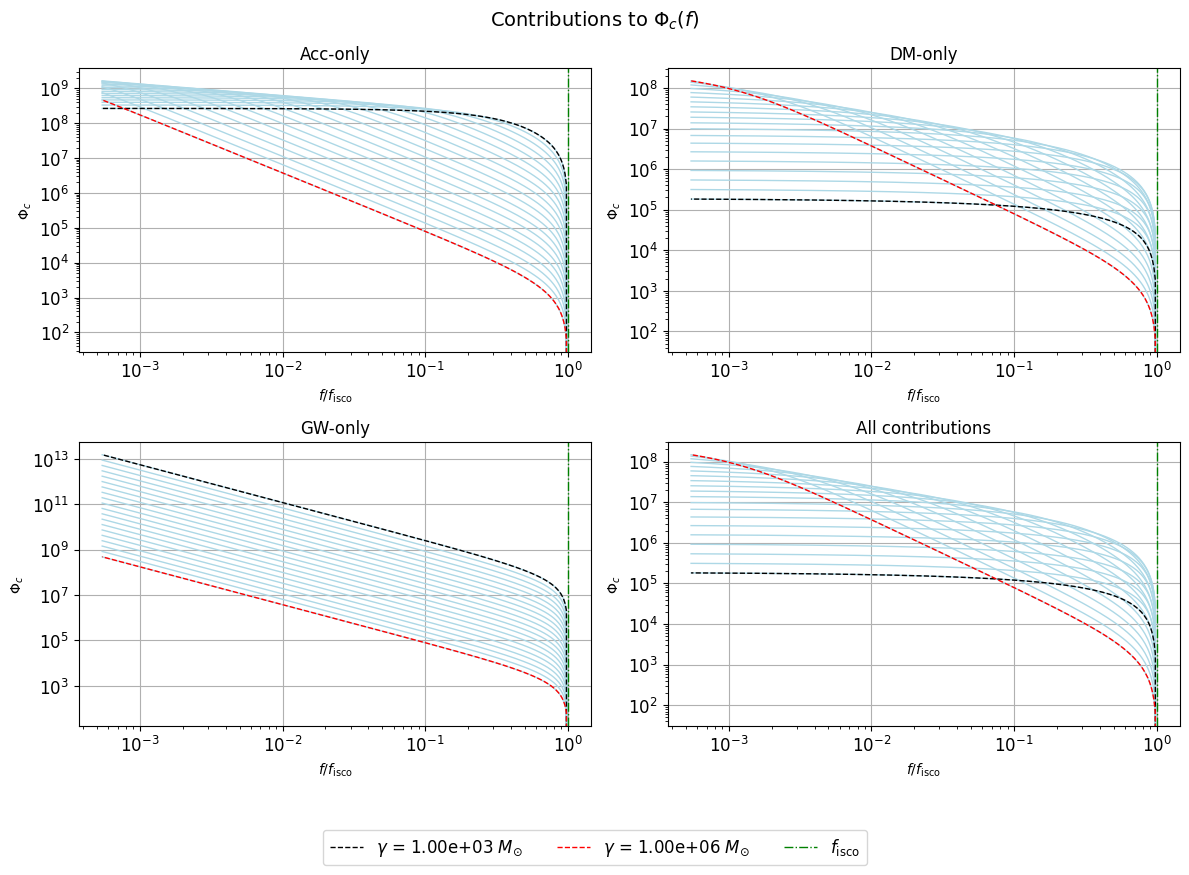

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))

plt.suptitle('Contributions to $\Phi_c(f)$', fontsize=14)

for i in range(0, len(phi_acc_s)):
    axs[0, 0].loglog(freqs/f_isco, -phi_acc_m[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[0, 0].loglog(freqs/f_isco, -phi_acc_m[0], label=f'$\gamma$ = {m1_vals[0]:.2e} $M_{{\odot}}$', linestyle='--', linewidth=1, c='black')
axs[0, 0].loglog(freqs/f_isco, -phi_acc_m[-1], label=f'$\gamma$ = {m1_vals[-1]:.2e} $M_{{\odot}}$', linestyle='--', linewidth=1, c='red')
axs[0, 0].axvline(x=1, c='green', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0, 0].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[0, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 0].grid(True)  # Add gridlines
axs[0, 0].set_title('Acc-only')  # Add gridlines
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(phi_acc_s)):
    axs[0, 1].loglog(freqs/f_isco, - phi_dm_m[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[0, 1].loglog(freqs/f_isco, - phi_dm_m[0], linestyle='--', linewidth=1, c='black')
axs[0, 1].loglog(freqs/f_isco, - phi_dm_m[-1], linestyle='--', linewidth=1, c='red')
axs[0, 1].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[0, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0, 1].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[0, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 1].grid(True)  # Add gridlines
axs[0, 1].set_title('DM-only')  # Add gridlines
#axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(phi_acc_s)):
    axs[1, 0].loglog(freqs/f_isco, -phi_gw_m[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[1, 0].loglog(freqs/f_isco, -phi_gw_m[0], linestyle='--', linewidth=1, c='black')
axs[1, 0].loglog(freqs/f_isco, -phi_gw_m[-1], linestyle='--', linewidth=1, c='red')
axs[1, 0].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[1, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1, 0].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[1, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 0].grid(True)  # Add gridlines
axs[1, 0].set_title('GW-only')  # Add gridlines
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(phi_acc_s)):
    axs[1, 1].loglog(freqs/f_isco, - phi_all_m[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[1, 1].loglog(freqs/f_isco, - phi_all_m[0], linestyle='--', linewidth=1, c='black')
axs[1, 1].loglog(freqs/f_isco, - phi_all_m[-1], linestyle='--', linewidth=1, c='red')
axs[1, 1].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[1, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1, 1].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[1, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 1].grid(True)  # Add gridlines
axs[1, 1].set_title('All contributions')  # Add gridlines
#axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/m1_phi.png')
plt.show()

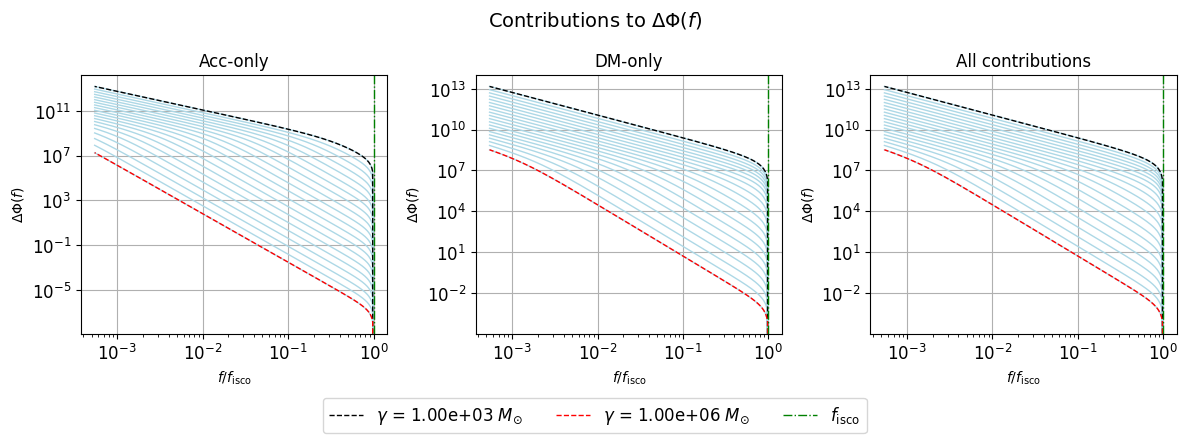

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))

plt.suptitle('Contributions to $\Delta\Phi(f)$', fontsize=14)

for i in range(0, len(phi_acc_m)):
    axs[0].loglog(freqs/f_isco, -phi_gw_m[i] + phi_acc_m[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[0].loglog(freqs/f_isco, -phi_gw_m[0] + phi_acc_m[0], label=f'$\gamma$ = {m1_vals[0]:.2e} $M_{{\odot}}$', linestyle='--', linewidth=1, c='black')
axs[0].loglog(freqs/f_isco, -phi_gw_m[-1] + phi_acc_m[-1], label=f'$\gamma$ = {m1_vals[-1]:.2e} $M_{{\odot}}$', linestyle='--', linewidth=1, c='red')
axs[0].axvline(x=1, c='green', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0].grid(True)  # Add gridlines
axs[0].set_title('Acc-only')  # Add gridlines
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(phi_acc_m)):
    axs[1].loglog(freqs/f_isco, -phi_gw_m[i] + phi_dm_m[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[1].loglog(freqs/f_isco, -phi_gw_m[0] + phi_dm_m[0], linestyle='--', linewidth=1, c='black')
axs[1].loglog(freqs/f_isco, -phi_gw_m[-1] + phi_dm_m[-1], linestyle='--', linewidth=1, c='red')
axs[1].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1].grid(True)  # Add gridlines
axs[1].set_title('DM-only')  # Add gridlines
#axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(phi_acc_m)):
    axs[2].loglog(freqs/f_isco, - phi_gw_m[i] + phi_all_m[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[2].loglog(freqs/f_isco,  -phi_gw_m[0] + phi_all_m[0], linestyle='--', linewidth=1, c='black')
axs[2].loglog(freqs/f_isco, -phi_gw_m[-1] + phi_all_m[-1], linestyle='--', linewidth=1, c='red')
axs[2].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[2].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[2].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[2].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[2].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[2].grid(True)  # Add gridlines
axs[2].set_title('All contributions')  # Add gridlines
#axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/m1_DELTA_phi.png')
plt.show()

### Varying $\Sigma_0$

In [20]:
phase_model_ss = [(Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = sigma0_vals[i], 
    gamma = -1/2, 
    gammas = 7/3, 
    rho6 = 1.17 * 1e17 * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)) for i in range(0, len(sigma0_vals))]                  

In [21]:
phi_all_ss = [(phase_model_ss[i].phase_f_by_hand_all(r_grid)) for i in range(0, len(phase_model_ss))]
phi_acc_ss = [(phase_model_ss[i].phase_f_by_hand_acc(r_grid)) for i in range(0, len(phase_model_ss))]
phi_gw_ss = [(phase_model_ss[i].phase_f_by_hand_gw(r_grid)) for i in range(0, len(phase_model_ss))]

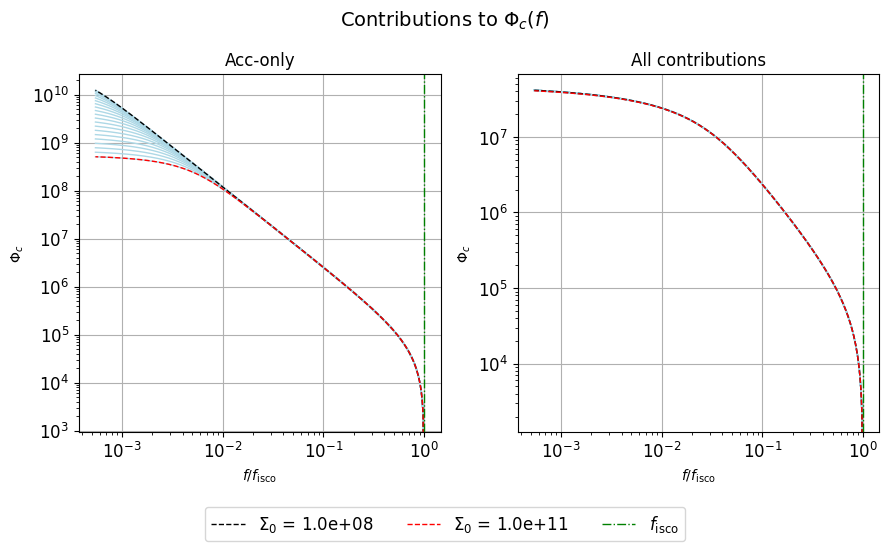

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(9,5))

plt.suptitle('Contributions to $\Phi_c(f)$', fontsize=14)

for i in range(0, len(phi_acc_ss)):
    axs[0].loglog(freqs/f_isco, -phi_acc_ss[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[0].loglog(freqs/f_isco, -phi_acc_ss[0], label=f'$\Sigma_0$ = {sigma0_vals[0]:.1e}', linestyle='--', linewidth=1, c='black')
axs[0].loglog(freqs/f_isco, -phi_acc_ss[-1], label=f'$\Sigma_0$ = {sigma0_vals[-1]:.1e}', linestyle='--', linewidth=1, c='red')
axs[0].axvline(x=1, c='green', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0].grid(True)  # Add gridlines
axs[0].set_title('Acc-only')  # Add gridlines
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(phi_acc_ss)):
    axs[1].loglog(freqs/f_isco, - phi_all_ss[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[1].loglog(freqs/f_isco, - phi_all_ss[0], linestyle='--', linewidth=1, c='black')
axs[1].loglog(freqs/f_isco, - phi_all_ss[-1], linestyle='--', linewidth=1, c='red')
axs[1].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1].grid(True)  # Add gridlines
axs[1].set_title('All contributions')  # Add gridlines
#axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/sigma0_accretion_phi.png')
plt.show()

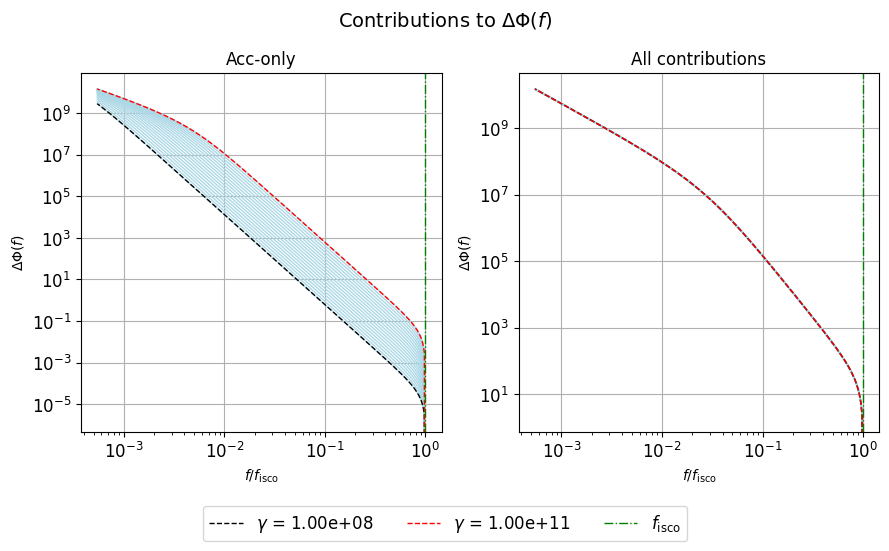

In [23]:
# Dephasing: 

fig, axs = plt.subplots(1, 2, figsize=(9,5))

plt.suptitle('Contributions to $\Delta\Phi(f)$', fontsize=14)

for i in range(0, len(phi_acc_ss)):
    axs[0].loglog(freqs/f_isco, phi_acc_ss[i] - phi_gw_ss[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[0].loglog(freqs/f_isco, phi_acc_ss[0] - phi_gw_ss[0], label=f'$\gamma$ = {sigma0_vals[0]:.2e}', linestyle='--', linewidth=1, c='black')
axs[0].loglog(freqs/f_isco, phi_acc_ss[-1] - phi_gw_ss[-1], label=f'$\gamma$ = {sigma0_vals[-1]:.2e}', linestyle='--', linewidth=1, c='red')
axs[0].axvline(x=1, c='green', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0].grid(True)  # Add gridlines
axs[0].set_title('Acc-only')  # Add gridlines
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(phi_acc_ss)):
    axs[1].loglog(freqs/f_isco, phi_all_ss[i] - phi_gw_ss[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[1].loglog(freqs/f_isco, phi_all_ss[0] - phi_gw_ss[0], linestyle='--', linewidth=1, c='black')
axs[1].loglog(freqs/f_isco, phi_all_ss[-1] - phi_gw_ss[-1], linestyle='--', linewidth=1, c='red')
axs[1].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1].grid(True)  # Add gridlines
axs[1].set_title('All contributions')
#axs[0, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/sigma0_accretion_DELTA_phi.png')
plt.show()

## Dark matter spike

I still keep here the static profile, while in the other notebook I try to implement a version for the non-static profile.

In [24]:
# Build array of gamma_s values and rho_s

gammas_vals = np.linspace(1/3, 2, 20)
rhodm_vals = np.logspace(15, 18, 20)

print("Gammass: ", gammas_vals)
print("Rhodms: ", rhodm_vals)

Gammass:  [0.33333333 0.45238095 0.57142857 0.69047619 0.80952381 0.92857143
 1.04761905 1.16666667 1.28571429 1.4047619  1.52380952 1.64285714
 1.76190476 1.88095238 2.        ]
Rhodms:  [1.00000000e+15 1.43844989e+15 2.06913808e+15 2.97635144e+15
 4.28133240e+15 6.15848211e+15 8.85866790e+15 1.27427499e+16
 1.83298071e+16 2.63665090e+16 3.79269019e+16 5.45559478e+16
 7.84759970e+16 1.12883789e+17 1.62377674e+17 2.33572147e+17
 3.35981829e+17 4.83293024e+17 6.95192796e+17 1.00000000e+18]


### Varying $\gamma_s$

In [45]:
phase_model_gammas = [(Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = 1.5 * 1e10, 
    gamma = -1/2, 
    gammas = gammas_vals[i], 
    rho6 = 1.17 * 1e17 * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)) for i in range(0, len(gammas_vals))]                  

In [46]:
phi_all_gammas = [(phase_model_gammas[i].phase_f_by_hand_all(r_grid)) for i in range(0, len(phase_model_gammas))]
phi_dm_gammas = [(phase_model_gammas[i].phase_f_by_hand_dm(r_grid)) for i in range(0, len(phase_model_gammas))]
phi_gw_gammas = [(phase_model_gammas[i].phase_f_by_hand_gw(r_grid)) for i in range(0, len(phase_model_gammas))]

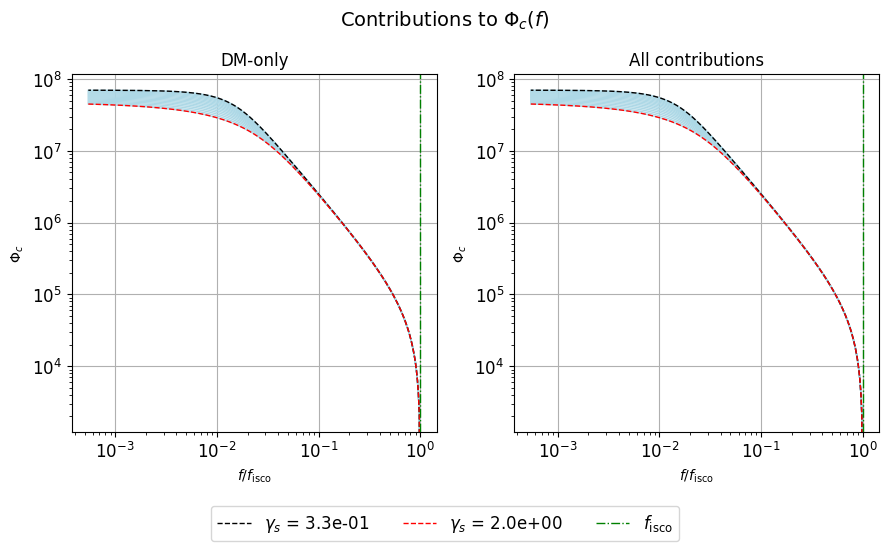

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(9,5))

plt.suptitle('Contributions to $\Phi_c(f)$', fontsize=14)

for i in range(0, len(phi_all_gammas)):
    axs[0].loglog(freqs/f_isco, -phi_dm_gammas[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[0].loglog(freqs/f_isco, -phi_dm_gammas[0], label=f'$\gamma_s$ = {gammas_vals[0]:.1e}', linestyle='--', linewidth=1, c='black')
axs[0].loglog(freqs/f_isco, -phi_dm_gammas[-1], label=f'$\gamma_s$ = {gammas_vals[-1]:.1e}', linestyle='--', linewidth=1, c='red')
axs[0].axvline(x=1, c='green', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0].grid(True)  # Add gridlines
axs[0].set_title('DM-only')  # Add gridlines
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(phi_all_gammas)):
    axs[1].loglog(freqs/f_isco, - phi_all_gammas[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[1].loglog(freqs/f_isco, - phi_all_gammas[0], linestyle='--', linewidth=1, c='black')
axs[1].loglog(freqs/f_isco, - phi_all_gammas[-1], linestyle='--', linewidth=1, c='red')
axs[1].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1].grid(True)  # Add gridlines
axs[1].set_title('All contributions')  # Add gridlines
#axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/gammas_dm_phi.png')
plt.show()

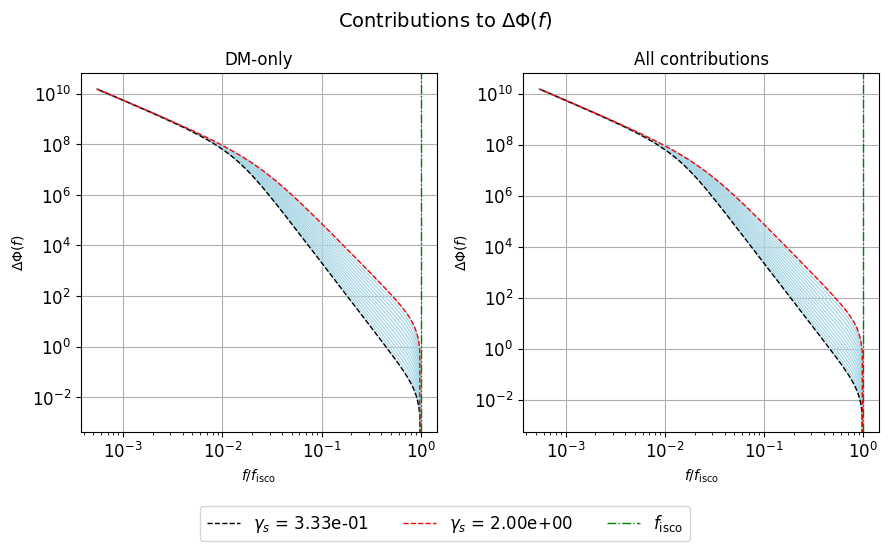

In [60]:
# Dephasing: 

fig, axs = plt.subplots(1, 2, figsize=(9,5))

plt.suptitle('Contributions to $\Delta\Phi(f)$', fontsize=14)

for i in range(0, len(phi_all_gammas)):
    axs[0].loglog(freqs/f_isco, phi_dm_gammas[i] - phi_gw_gammas[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[0].loglog(freqs/f_isco, phi_dm_gammas[0] - phi_gw_gammas[0], label=f'$\gamma_s$ = {gammas_vals[0]:.2e}', linestyle='--', linewidth=1, c='black')
axs[0].loglog(freqs/f_isco, phi_dm_gammas[-1] - phi_gw_gammas[-1], label=f'$\gamma_s$ = {gammas_vals[-1]:.2e}', linestyle='--', linewidth=1, c='red')
axs[0].axvline(x=1, c='green', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0].grid(True)  # Add gridlines
axs[0].set_title('DM-only')  # Add gridlines
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(phi_all_gammas)):
    axs[1].loglog(freqs/f_isco, phi_all_gammas[i] - phi_gw_gammas[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[1].loglog(freqs/f_isco, phi_all_gammas[0] - phi_gw_gammas[0], linestyle='--', linewidth=1, c='black')
axs[1].loglog(freqs/f_isco, phi_all_gammas[-1] - phi_gw_gammas[-1], linestyle='--', linewidth=1, c='red')
axs[1].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1].grid(True)  # Add gridlines
axs[1].set_title('All contributions')
#axs[0, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/gamma_dm_DELTA_phi.png')
plt.show()

### Varying $\rho_s$

In [57]:
phase_model_rhodm = [(Phase_Evaluation(

    m1 = m_sun * 1e5, 
    m2 = m_sun * 10,
    mach = 100, 
    sigma0 = 1.5 * 1e10, 
    gamma = -1/2, 
    gammas = 7/3, 
    rho6 = rhodm_vals[i] * m_sun / (pc)**3, 
    r6 = pc / 1e6, 
    epsv = 0.58, 
    dist = 4 * 1e9 * pc

)) for i in range(0, len(rhodm_vals))]                  

In [58]:
phi_all_rhodm = [(phase_model_rhodm[i].phase_f_by_hand_all(r_grid)) for i in range(0, len(phase_model_rhodm))]
phi_dm_rhodm = [(phase_model_rhodm[i].phase_f_by_hand_dm(r_grid)) for i in range(0, len(phase_model_rhodm))]
phi_gw_rhodm = [(phase_model_rhodm[i].phase_f_by_hand_gw(r_grid)) for i in range(0, len(phase_model_rhodm))]

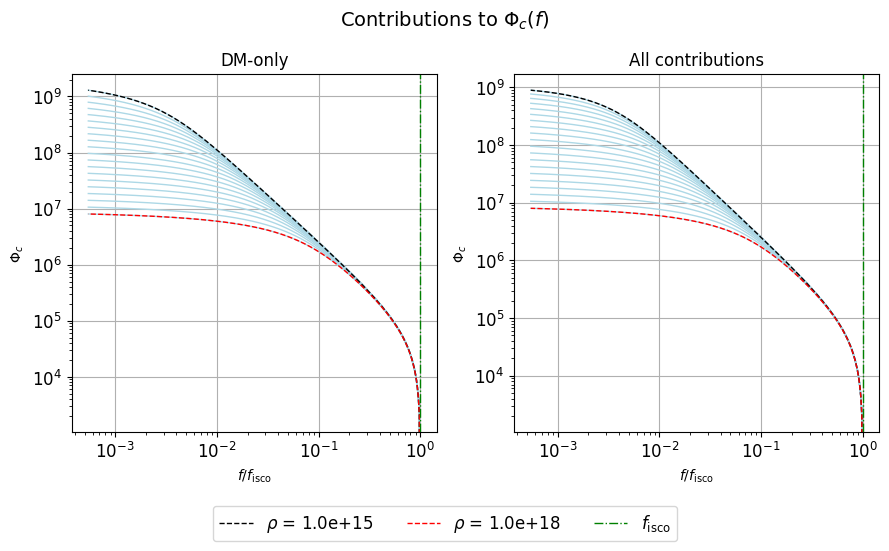

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(9,5))

plt.suptitle('Contributions to $\Phi_c(f)$', fontsize=14)

for i in range(0, len(phi_dm_rhodm)):
    axs[0].loglog(freqs/f_isco, -phi_dm_rhodm[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[0].loglog(freqs/f_isco, -phi_dm_rhodm[0], label=fr'$\rho$ = {rhodm_vals[0]:.1e}', linestyle='--', linewidth=1, c='black')
axs[0].loglog(freqs/f_isco, -phi_dm_rhodm[-1], label=fr'$\rho$ = {rhodm_vals[-1]:.1e}', linestyle='--', linewidth=1, c='red')
axs[0].axvline(x=1, c='green', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0].grid(True)  # Add gridlines
axs[0].set_title('DM-only')  # Add gridlines
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(phi_dm_rhodm)):
    axs[1].loglog(freqs/f_isco, - phi_all_rhodm[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[1].loglog(freqs/f_isco, - phi_all_rhodm[0], linestyle='--', linewidth=1, c='black')
axs[1].loglog(freqs/f_isco, - phi_all_rhodm[-1], linestyle='--', linewidth=1, c='red')
axs[1].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1].grid(True)  # Add gridlines
axs[1].set_title('All contributions')  # Add gridlines
#axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/rho_dm_phi.png')
plt.show()

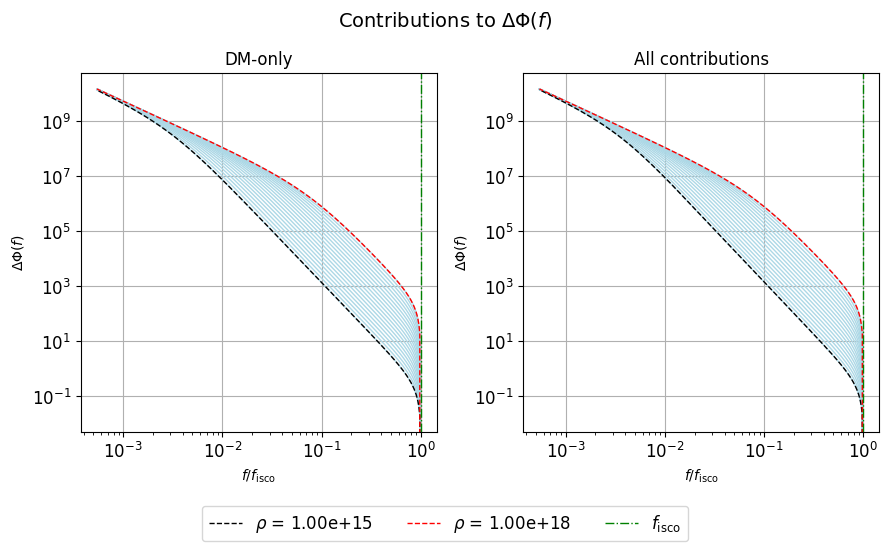

In [67]:
# Dephasing: 

fig, axs = plt.subplots(1, 2, figsize=(9,5))

plt.suptitle('Contributions to $\Delta\Phi(f)$', fontsize=14)

for i in range(0, len(phi_all_rhodm)):
    axs[0].loglog(freqs/f_isco, phi_dm_rhodm[i] - phi_gw_rhodm[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[0].loglog(freqs/f_isco, phi_dm_rhodm[0] - phi_gw_rhodm[0], label=fr'$\rho$ = {rhodm_vals[0]:.2e}', linestyle='--', linewidth=1, c='black')
axs[0].loglog(freqs/f_isco, phi_dm_rhodm[-1] - phi_gw_rhodm[-1], label=fr'$\rho$ = {rhodm_vals[-1]:.2e}', linestyle='--', linewidth=1, c='red')
axs[0].axvline(x=1, c='green', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0].grid(True)  # Add gridlines
axs[0].set_title('DM-only')  # Add gridlines
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(phi_all_rhodm)):
    axs[1].loglog(freqs/f_isco, phi_all_rhodm[i] - phi_gw_rhodm[i], c='lightblue', linestyle='-', linewidth=1)
    
axs[1].loglog(freqs/f_isco, phi_all_rhodm[0] - phi_gw_rhodm[0], linestyle='--', linewidth=1, c='black')
axs[1].loglog(freqs/f_isco, phi_all_rhodm[-1] - phi_gw_rhodm[-1], linestyle='--', linewidth=1, c='red')
axs[1].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1].grid(True)  # Add gridlines
axs[1].set_title('All contributions')
#axs[0, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/rho_dm_DELTA_phi.png')
plt.show()